In [2]:
import numpy as np
import matplotlib.pyplot as plt
import random as rnd
import seaborn as sns
from math import exp

We Improve on the energy calculation by only calcualting the difference in energy between two states, rather than calculating the energy for the entire state

In [3]:
def energy(state, J):
    L = state.shape[0]
    e = 0.0
    for i in range(L):
        for j in range(L):
            for k in range(L):
                s = state[i, j, k]
                e -= J * s * state[(i + 1) % L, j, k]
                e -= J * s * state[i, (j + 1) % L, k]
                e -= J * s * state[i, j, (k + 1) % L]
    return e

def neighbor_sum(state, i, j, k):
    L = state.shape[0]
    return (
        state[(i + 1) % L, j, k] +
        state[(i - 1) % L, j, k] +
        state[i, (j + 1) % L, k] +
        state[i, (j - 1) % L, k] +
        state[i, j, (k + 1) % L] +
        state[i, j, (k - 1) % L]
    )

def local_deltaE(state, i, j, k, J):
    s = state[i, j, k]
    nn = neighbor_sum(state, i, j, k)
    return 2.0 * J * s * nn


In [4]:
def metropolis(e_old, e_new, T):
    if e_new < e_old:
        return True
    else:
        if np.random.random() < exp((e_old - e_new) / T):
            return True
        return False
    
def flip(state, i, j, k):
    state[i, j, k] = -state[i, j, k]

def magnetization(state):
    return np.sum(state) / state.size

We implement Wolff's method here, so we can compare it to Metropolis'. Wolff step calcualtes which molecuels to switch, wolff sweep flips the entire cluster that was returned by Wollf step

In [5]:
# def wolff_step(state, T, J):
#     """
#     Perform ONE Wolff cluster flip, h = 0.
#     Returns cluster size.
#     """
#     L = state.shape[0]
#     beta = 1.0 / T
#     p_add = 1.0 - exp(-2.0 * beta * J)

#     # random seed spin
#     i0 = np.random.randint(0, L)
#     j0 = np.random.randint(0, L)
#     k0 = np.random.randint(0, L)
#     spin0 = state[i0, j0, k0]

#     visited = np.zeros_like(state, dtype=bool)
#     stack = [(i0, j0, k0)]
#     visited[i0, j0, k0] = True

#     cluster = []

#     while stack:
#         i, j, k = stack.pop()
#         cluster.append((i, j, k))

#         neighbours = (
#             ((i + 1) % L, j, k),
#             ((i - 1) % L, j, k),
#             (i, (j + 1) % L, k),
#             (i, (j - 1) % L, k),
#             (i, j, (k + 1) % L),
#             (i, j, (k - 1) % L),
#         )

#         for ni, nj, nk in neighbours:
#             if visited[ni, nj, nk]:
#                 continue
#             if state[ni, nj, nk] != spin0:
#                 continue
#             if np.random.random() < p_add:
#                 visited[ni, nj, nk] = True
#                 stack.append((ni, nj, nk))

#     # flip entire cluster
#     for (i, j, k) in cluster:
#         state[i, j, k] = -state[i, j, k]

#     return len(cluster)


# def wolff_sweep(state, T, J):
#     """
#     Flip clusters until total flipped spins >= N (one 'effective sweep').
#     """
#     L = state.shape[0]
#     N = L ** 3
#     flipped = 0
#     while flipped < N:
#         flipped += wolff_step(state, T, J)

def wolff_step(state, T, J):
    """
    Perform ONE Wolff cluster flip. Calculates and returns the energy change (dE).
    """
    L = state.shape[0]
    beta = 1.0 / T
    # Probability to ADD a parallel spin to the cluster
    p_add = 1.0 - exp(-2.0 * beta * J)

    # random seed spin
    i0 = np.random.randint(0, L)
    j0 = np.random.randint(0, L)
    k0 = np.random.randint(0, L)
    spin0 = state[i0, j0, k0] # Spin of the cluster

    visited = np.zeros_like(state, dtype=bool)
    stack = [(i0, j0, k0)]
    visited[i0, j0, k0] = True
    cluster = []
    
    ### CHANGE: Initialize Delta E calculation
    dE = 0.0 

    while stack:
        i, j, k = stack.pop()
        cluster.append((i, j, k))

        # Get the six neighbors' coordinates (using periodic boundary conditions)
        neighbours = (
            ((i + 1) % L, j, k), ((i - 1) % L, j, k),
            (i, (j + 1) % L, k), (i, (j - 1) % L, k),
            (i, j, (k + 1) % L), (i, j, (k - 1) % L),
        )

        for ni, nj, nk in neighbours:
            
            # Check if neighbor is already part of the growing cluster
            if visited[ni, nj, nk]:
                continue
            
            spin_n = state[ni, nj, nk]

            if spin_n == spin0:
                # Case 1: Parallel spin neighbor. Check if bond is added or forms a boundary.
                if np.random.random() < p_add:
                    visited[ni, nj, nk] = True
                    stack.append((ni, nj, nk))
                else:
                    ### CHANGE: Boundary bond formed (Parallel, NOT added)
                    # s_i * s_j = +1. Changes from -J(+1) to -J(-1). dE = +2J.
                    dE += 2.0 * J
            else: 
                # Case 2: Anti-parallel spin neighbor. Always a boundary bond (Cannot be added).
                ### CHANGE: Boundary bond formed (Anti-parallel)
                # s_i * s_j = -1. Changes from -J(-1) to -J(+1). dE = -2J.
                dE -= 2.0 * J

    # flip entire cluster
    for (i, j, k) in cluster:
        state[i, j, k] = -state[i, j, k]

    ### CHANGE: Return both cluster size and Delta E
    return len(cluster), dE


In [10]:
side = 10
t = 2
J = 1.0  
nstep = 50000
seed = 42  
state = 2 * np.random.randint(2, size=(side, side, side)) - 1
np.random.seed(seed)

Here we create a function to run the dynamics, where we can change which method we want to use (Metroplis vs Wolff)

In [7]:
# def run_dynamics(state, J, T, nstep, algo="metropolis"):
#     """
#     Run nstep Monte Carlo steps with either Metropolis or Wolff.

#     state : 3D array (modified in-place)
#     J, T  : coupling, temperature
#     nstep : number of MC steps
#     algo  : "metropolis" or "wolff"

#     Returns
#     -------
#     e_history, m_history : lists of energy and magnetisation per step
#     """
#     L = state.shape[0]

#     e_old = energy(state, J)

#     e_history = []
#     m_history = []

#     for istep in range(nstep):
#         if algo == "metropolis":
#             # single-spin Metropolis with local ΔE
#             i = np.random.randint(L)
#             j = np.random.randint(L)
#             k = np.random.randint(L)

#             dE = local_deltaE(state, i, j, k, J)
#             e_new = e_old + dE

#             if metropolis(e_old, e_new, T):
#                 flip(state, i, j, k)
#                 e_old = e_new
#             # else: reject, do nothing

#         elif algo == "wolff":
#             wolff_step(state, T, J)
#             # recompute full energy after the cluster flip
#             e_old = energy(state, J)

#         else:
#             raise ValueError("algo must be 'metropolis' or 'wolff'")

#         e_history.append(e_old)
#         m_history.append(magnetization(state))

#     return e_history, m_history


def run_dynamics(state, J, T, nstep, algo="metropolis"):
    """
    Run nstep Monte Carlo steps with either Metropolis or Wolff.
    """
    L = state.shape[0]

    e_old = energy(state, J)

    e_history = []
    m_history = []

    for istep in range(nstep):
        if algo == "metropolis":
            # ... (Metropolis block remains the same, as it was already efficient)
            i = np.random.randint(L)
            j = np.random.randint(L)
            k = np.random.randint(L)

            dE = local_deltaE(state, i, j, k, J)
            e_new = e_old + dE

            if metropolis(e_old, e_new, T):
                flip(state, i, j, k)
                e_old = e_new
            # else: reject, do nothing

        elif algo == "wolff":
            ### CHANGE: Use efficient wolff_step and update energy
            cluster_size, dE = wolff_step(state, T, J)
            e_old += dE # O(1) energy update!

        else:
            raise ValueError("algo must be 'metropolis' or 'wolff'")

        e_history.append(e_old)
        m_history.append(magnetization(state))
        print(e_old)

    return e_history, m_history

In [ ]:
#e_history, m_history = run_dynamics(state, J, t, nstep, algo="metropolis")

e_history, m_history = run_dynamics(state, J, t, nstep, algo="wolff")

-702.0
-1946.0
-1280.0
-164.0
914.0
2096.0
3054.0
4192.0
5380.0
6386.0
7532.0
8670.0
9720.0
10936.0
12098.0
13388.0
14502.0
15668.0
16828.0
17760.0
18914.0
20088.0
21212.0
22272.0
23414.0
24460.0
25622.0
26748.0
27900.0
29012.0
30162.0
31296.0
32364.0
33594.0
34622.0
35796.0
36900.0
38022.0
39146.0
40322.0
41530.0
42624.0
43770.0
44934.0
46090.0
47210.0
48318.0
49434.0
50596.0
51792.0
52982.0
53972.0
55092.0
56316.0
57304.0
58484.0
59670.0
60704.0
61892.0
63096.0
64156.0
65284.0
66458.0
67660.0
68692.0
69788.0
70844.0
72018.0
73102.0
74232.0
75334.0
76592.0
77730.0
78860.0
79970.0
81078.0
82240.0
83284.0
84516.0
85590.0
86706.0
87778.0
88858.0
89848.0
90998.0
92088.0
93156.0
94214.0
95190.0
96396.0
97554.0
98778.0
100056.0
101212.0
102426.0
103586.0
104752.0
105882.0
106966.0
108060.0
109390.0
110418.0
111594.0
112710.0
113892.0
115052.0
116214.0
117290.0
118440.0
119594.0
120732.0
121894.0
123042.0
124088.0
125300.0
126448.0
127620.0
128576.0
129766.0
130908.0
131938.0
133078.0
134164

In [9]:
# discard first 1/3 of samples
cut = int(nstep/3)
e_sel = e_history[cut:]
m_sel = m_history[cut:]

avE = np.mean(e_sel)
avM = np.mean(m_sel)

print("Average energy:", avE)
print("Average magnetization:", avM)


Average energy: -22.971260574788506
Average magnetization: 0.014840823183536331


In [3]:
import numpy as np
import matplotlib.pyplot as plt
import random as rnd
import seaborn as sns
from math import exp

def energy(state, J):
    L = state.shape[0]
    e = 0.0
    for i in range(L):
        for j in range(L):
            for k in range(L):
                s = state[i, j, k]
                e -= J * s * state[(i + 1) % L, j, k]
                e -= J * s * state[i, (j + 1) % L, k]
                e -= J * s * state[i, j, (k + 1) % L]
    return e

def neighbor_sum(state, i, j, k):
    L = state.shape[0]
    return (
        state[(i + 1) % L, j, k] +
        state[(i - 1) % L, j, k] +
        state[i, (j + 1) % L, k] +
        state[i, (j - 1) % L, k] +
        state[i, j, (k + 1) % L] +
        state[i, j, (k - 1) % L]
    )

def local_deltaE(state, i, j, k, J):
    s = state[i, j, k]
    nn = neighbor_sum(state, i, j, k)
    return 2.0 * J * s * nn

def metropolis(e_old, e_new, T):
    if e_new < e_old:
        return True
    else:
        if np.random.random() < exp((e_old - e_new) / T):
            return True
        return False
    
def flip(state, i, j, k):
    state[i, j, k] = -state[i, j, k]

def magnetization(state):
    return np.sum(state) / state.size

def wolff_step(state, T, J):
    """
    Perform ONE Wolff cluster flip. Calculates and returns the energy change (dE).
    """
    L = state.shape[0]
    beta = 1.0 / T
    p_add = 1.0 - exp(-2.0 * beta * J)

    i0 = np.random.randint(0, L)
    j0 = np.random.randint(0, L)
    k0 = np.random.randint(0, L)
    spin0 = state[i0, j0, k0] 

    visited = np.zeros_like(state, dtype=bool)
    stack = [(i0, j0, k0)]
    visited[i0, j0, k0] = True
    cluster = []
    
    # --- PHASE 1: Build the Cluster ---
    while stack:
        i, j, k = stack.pop()
        cluster.append((i, j, k))

        # Get neighbors
        neighbours = (
            ((i + 1) % L, j, k), ((i - 1) % L, j, k),
            (i, (j + 1) % L, k), (i, (j - 1) % L, k),
            (i, j, (k + 1) % L), (i, j, (k - 1) % L),
        )

        for ni, nj, nk in neighbours:
            if visited[ni, nj, nk]:
                continue
            
            if state[ni, nj, nk] == spin0:
                if np.random.random() < p_add:
                    visited[ni, nj, nk] = True
                    stack.append((ni, nj, nk))

    # --- PHASE 2: Calculate dE based on final Cluster Boundary ---
    dE = 0.0
    for i, j, k in cluster:
        # Check all 6 neighbors again to find the true boundary
        neighbours = (
            ((i + 1) % L, j, k), ((i - 1) % L, j, k),
            (i, (j + 1) % L, k), (i, (j - 1) % L, k),
            (i, j, (k + 1) % L), (i, j, (k - 1) % L),
        )
        
        for ni, nj, nk in neighbours:
            # If the neighbor is NOT in the cluster, this bond changes energy
            if not visited[ni, nj, nk]:
                # Interaction energy is -J * s_i * s_j
                # s_i flips, s_j stays. 
                # dE = E_new - E_old 
                #    = (-J * (-s_i) * s_j) - (-J * s_i * s_j)
                #    = 2 * J * s_i * s_j
                
                s_i = state[i, j, k]
                s_j = state[ni, nj, nk]
                dE += 2.0 * J * s_i * s_j

    # --- PHASE 3: Flip ---
    for (i, j, k) in cluster:
        state[i, j, k] = -state[i, j, k]

    return len(cluster), dE


side = 10
t = 4
J = 1.0  
nstep = 50000
seed = 67  
state = 2 * np.random.randint(2, size=(side, side, side)) - 1
np.random.seed(seed)


def run_dynamics(state, J, T, nstep, algo="metropolis"):
    """
    Run nstep Monte Carlo steps with either Metropolis or Wolff.
    """
    L = state.shape[0]

    e_old = energy(state, J)

    e_history = []
    m_history = []

    for istep in range(nstep):
        if algo == "metropolis":
            # ... (Metropolis block remains the same, as it was already efficient)
            i = np.random.randint(L)
            j = np.random.randint(L)
            k = np.random.randint(L)

            dE = local_deltaE(state, i, j, k, J)
            e_new = e_old + dE

            if metropolis(e_old, e_new, T):
                flip(state, i, j, k)
                e_old = e_new
            # else: reject, do nothing

        elif algo == "wolff":
            ### CHANGE: Use efficient wolff_step and update energy
            cluster_size, dE = wolff_step(state, T, J)
            e_old += dE # O(1) energy update!

        else:
            raise ValueError("algo must be 'metropolis' or 'wolff'")

        e_history.append(e_old)
        m_history.append(magnetization(state))
        print(e_old)

    return e_history, m_history


e_history, m_history = run_dynamics(state, J, t, nstep, algo="wolff")

# discard first 1/3 of samples
cut = int(nstep/3)
e_sel = e_history[cut:]
m_sel = m_history[cut:]

avE = np.mean(e_sel)
avM = np.mean(m_sel)

print("Average energy:", avE)
print("Average magnetization:", avM)

28.0
20.0
16.0
4.0
-124.0
-136.0
-148.0
-148.0
-160.0
-248.0
-248.0
-248.0
-276.0
-280.0
-292.0
-292.0
-312.0
-328.0
-364.0
-384.0
-508.0
-584.0
-1008.0
-1012.0
-1012.0
-1060.0
-1432.0
-1500.0
-1492.0
-1648.0
-1516.0
-1528.0
-1492.0
-1504.0
-1536.0
-1780.0
-1936.0
-2080.0
-2080.0
-1840.0
-1844.0
-1980.0
-1924.0
-1868.0
-1956.0
-1972.0
-1964.0
-1976.0
-1840.0
-2036.0
-1684.0
-1428.0
-1488.0
-1480.0
-1732.0
-1904.0
-1652.0
-1648.0
-1908.0
-1956.0
-1956.0
-2052.0
-1924.0
-1636.0
-1740.0
-1684.0
-1680.0
-1688.0
-1768.0
-1724.0
-2020.0
-1944.0
-1848.0
-1996.0
-2008.0
-2000.0
-1684.0
-1900.0
-1944.0
-1948.0
-1868.0
-2116.0
-2048.0
-1844.0
-1784.0
-1968.0
-1912.0
-1880.0
-1852.0
-1864.0
-1984.0
-1896.0
-1812.0
-1920.0
-1804.0
-1884.0
-1892.0
-1912.0
-2144.0
-2044.0
-1956.0
-1968.0
-2080.0
-1984.0
-2012.0
-2020.0
-2092.0
-2024.0
-1904.0
-2020.0
-2032.0
-1896.0
-1904.0
-1856.0
-1868.0
-1896.0
-1996.0
-1976.0
-2120.0
-2028.0
-1940.0
-1924.0
-1580.0
-1592.0
-1612.0
-1748.0
-1908.0
-1900.0
-1880.0

<>:182: SyntaxWarning: invalid escape sequence '\s'
<>:182: SyntaxWarning: invalid escape sequence '\s'
C:\Users\leona\AppData\Local\Temp\ipykernel_32088\2567313927.py:182: SyntaxWarning: invalid escape sequence '\s'
  ax1.axvline(x=4.51, color='gray', linestyle=':', label='$T_c \sim 4.51$ (Expected)')


Starting Scan (L=10x10x10, J=1.0). Steps/T: 10000 (Thermalization: 3000)
T=3.00 done. <|M|>=0.9457
T=3.10 done. <|M|>=0.9361
T=3.20 done. <|M|>=0.9242
T=3.30 done. <|M|>=0.9124
T=3.40 done. <|M|>=0.8972
T=3.50 done. <|M|>=0.8810
T=3.60 done. <|M|>=0.8618
T=3.70 done. <|M|>=0.8408
T=3.80 done. <|M|>=0.8142
T=3.90 done. <|M|>=0.7848
T=4.00 done. <|M|>=0.7506
T=4.10 done. <|M|>=0.7085
T=4.20 done. <|M|>=0.6610
T=4.30 done. <|M|>=0.5849
T=4.40 done. <|M|>=0.4858
T=4.50 done. <|M|>=0.3325
T=4.60 done. <|M|>=0.2429
T=4.70 done. <|M|>=0.1842
T=4.80 done. <|M|>=0.1466
T=4.90 done. <|M|>=0.1198
T=5.00 done. <|M|>=0.1096
T=5.10 done. <|M|>=0.0963
T=5.20 done. <|M|>=0.0913
T=5.30 done. <|M|>=0.0875
T=5.40 done. <|M|>=0.0796
T=5.50 done. <|M|>=0.0707
T=5.60 done. <|M|>=0.0755
T=5.70 done. <|M|>=0.0696
T=5.80 done. <|M|>=0.0622
T=5.90 done. <|M|>=0.0632
T=6.00 done. <|M|>=0.0662


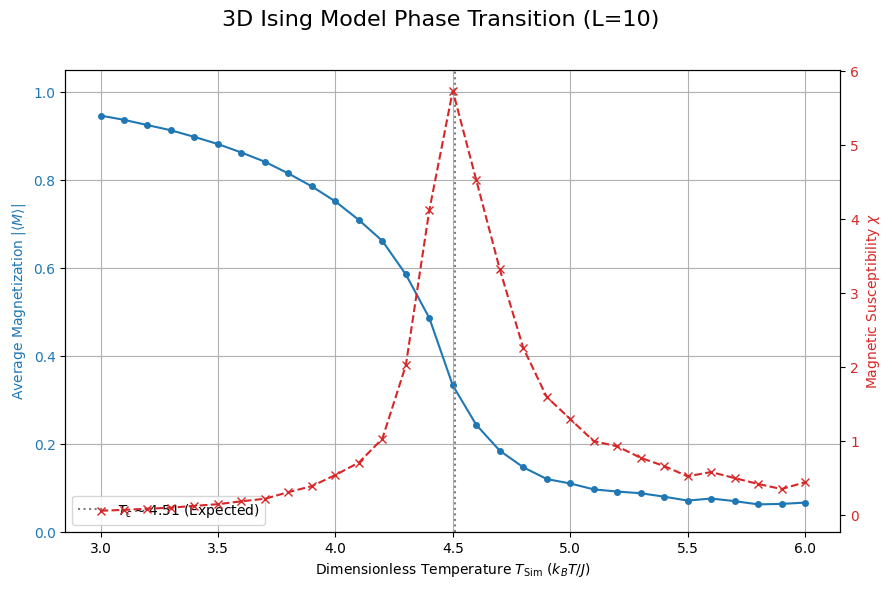


--- Interpretation ---
1. Find the Critical Temperature (Tc) of your model where the Magnetization drops to zero and the Susceptibility (red line) peaks.
2. Use this value (T_c_model) to calculate J_effective using: J_effective = (k_B * T_c_Iron) / T_c_model


In [4]:
import numpy as np
import matplotlib.pyplot as plt
from math import exp, log
import random as rnd

# --- Utility Functions (Provided by User) ---

def energy(state, J):
    L = state.shape[0]
    e = 0.0
    # Note: This energy function correctly sums bonds once due to periodic wrapping
    for i in range(L):
        for j in range(L):
            for k in range(L):
                s = state[i, j, k]
                # Only check bonds in +x, +y, +z directions to avoid double counting
                e -= J * s * state[(i + 1) % L, j, k]
                e -= J * s * state[i, (j + 1) % L, k]
                e -= J * s * state[i, j, (k + 1) % L]
    return e

def magnetization(state):
    return np.sum(state) / state.size

# --- Wolff Algorithm (Corrected for dE calculation) ---

def wolff_step(state, T, J):
    L = state.shape[0]
    beta = 1.0 / T
    # Probability to ADD a parallel spin to the cluster
    p_add = 1.0 - exp(-2.0 * beta * J)

    i0, j0, k0 = np.random.randint(0, L, 3)
    spin0 = state[i0, j0, k0] # Spin of the cluster

    visited = np.zeros_like(state, dtype=bool)
    stack = [(i0, j0, k0)]
    visited[i0, j0, k0] = True
    cluster = []
    
    # PHASE 1: Build the Cluster
    while stack:
        i, j, k = stack.pop()
        cluster.append((i, j, k))

        neighbours = (
            ((i + 1) % L, j, k), ((i - 1) % L, j, k),
            (i, (j + 1) % L, k), (i, (j - 1) % L, k),
            (i, j, (k + 1) % L), (i, j, (k - 1) % L),
        )

        for ni, nj, nk in neighbours:
            if visited[ni, nj, nk]:
                continue
            
            spin_n = state[ni, nj, nk]

            if spin_n == spin0:
                if np.random.random() < p_add:
                    visited[ni, nj, nk] = True
                    stack.append((ni, nj, nk))

    # PHASE 2: Calculate dE based on final Cluster Boundary (Corrected Logic)
    dE = 0.0
    for i, j, k in cluster:
        neighbours = (
            ((i + 1) % L, j, k), ((i - 1) % L, j, k),
            (i, (j + 1) % L, k), (i, (j - 1) % L, k),
            (i, j, (k + 1) % L), (i, j, (k - 1) % L),
        )
        
        for ni, nj, nk in neighbours:
            if not visited[ni, nj, nk]:
                s_i = state[i, j, k]
                s_j = state[ni, nj, nk]
                # dE = 2 * J * s_i * s_j
                dE += 2.0 * J * s_i * s_j

    # PHASE 3: Flip the cluster
    for (i, j, k) in cluster:
        state[i, j, k] = -state[i, j, k]

    return len(cluster), dE

# --- Dynamics Runner ---

def run_dynamics(state, T, J, n_steps, n_therm):
    """
    Runs Monte Carlo steps and returns average Magnetization and M^2.
    """
    e_old = energy(state, J) 
    m_history = []
    m2_history = []

    for istep in range(n_steps):
        cluster_size, dE = wolff_step(state, T, J)
        e_old += dE # Update energy efficiently

        if istep >= n_therm:
            m = magnetization(state)
            m_history.append(abs(m)) # Use absolute magnetization for averaging
            m2_history.append(m**2)

    return np.mean(m_history), np.mean(m2_history)

# --- Main Scan Function ---

def temperature_scan(L, J, T_min, T_max, T_step, N_steps_total, N_therm_ratio):
    
    Ts = np.arange(T_min, T_max + T_step, T_step)
    
    M_avg = []
    Chi_avg = []
    
    N_therm = int(N_steps_total * N_therm_ratio)
    
    # Initialize state (random start for rapid thermalization)
    initial_state = 2 * np.random.randint(2, size=(L, L, L)) - 1
    
    print(f"Starting Scan (L={L}x{L}x{L}, J={J}). Steps/T: {N_steps_total} (Thermalization: {N_therm})")
    
    # Loop over temperatures
    for T in Ts:
        # Create a deep copy of the initial state to run each T independently
        state = initial_state.copy() 
        
        # Run dynamics and get averages
        m_mean, m2_mean = run_dynamics(state, T, J, N_steps_total, N_therm)
        
        # Calculate susceptibility (Chi)
        # Chi = (N/kT) * (<M^2> - <M>^2)
        N = L**3
        # Since k_B = 1 in our dimensionless units:
        chi = (N / T) * (m2_mean - m_mean**2)
        
        M_avg.append(m_mean)
        Chi_avg.append(chi)
        
        # Simple progress update
        print(f"T={T:.2f} done. <|M|>={m_mean:.4f}")

    return Ts, M_avg, Chi_avg

# --- Execution ---

# Configuration
LATTICE_SIZE = 10
J_VAL = 1.0 
T_START = 3.0
T_END = 6.0
T_STEP = 0.1 # Fine steps give a better curve
TOTAL_STEPS = 10000 
THERMALIZATION_RATIO = 0.3 # Discard first 30% of steps

# Run the experiment
Ts, M_vals, Chi_vals = temperature_scan(
    LATTICE_SIZE, J_VAL, T_START, T_END, T_STEP, TOTAL_STEPS, THERMALIZATION_RATIO
)

# --- Plotting Results ---

fig, ax1 = plt.subplots(figsize=(10, 6))
fig.suptitle(f'3D Ising Model Phase Transition (L={LATTICE_SIZE})', fontsize=16)

# Plot Magnetization (|M|) on the left axis
color = 'tab:blue'
ax1.set_xlabel(r'Dimensionless Temperature $T_{\text{Sim}}$ ($k_B T/J$)')
ax1.set_ylabel(r'Average Magnetization $|\langle M \rangle|$', color=color)
ax1.plot(Ts, M_vals, color=color, marker='o', markersize=4, linestyle='-')
ax1.tick_params(axis='y', labelcolor=color)
ax1.grid(True)
ax1.set_ylim(0, 1.05) # M cannot exceed 1

# Instantiate a second axes that shares the same x-axis
ax2 = ax1.twinx()  
color = 'tab:red'
ax2.set_ylabel(r'Magnetic Susceptibility $\chi$', color=color)  
ax2.plot(Ts, Chi_vals, color=color, marker='x', markersize=6, linestyle='--')
ax2.tick_params(axis='y', labelcolor=color)

# Add an estimate for the known Tc (4.51)
ax1.axvline(x=4.51, color='gray', linestyle=':', label='$T_c \sim 4.51$ (Expected)')
ax1.legend(loc='lower left')

plt.show()

# --- Interpretation Prompt ---
print("\n--- Interpretation ---")
print("1. Find the Critical Temperature (Tc) of your model where the Magnetization drops to zero and the Susceptibility (red line) peaks.")
print("2. Use this value (T_c_model) to calculate J_effective using: J_effective = (k_B * T_c_Iron) / T_c_model")